In [19]:
!pip install wget
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
import os
import re
import pandas as pd

#helper functions to lead the data
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz",
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
      extract=True)

    train_df = load_dataset(os.path.join(os.path.dirname(dataset),
                                       "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset),
                                      "aclImdb", "test"))

    return train_df, test_df

## Store external datasets in local environments - Load and preprocess data

In [4]:
try:
    from google.colab import files

    if not os.path.exists('aclImdb'):
        train,test = download_and_load_datasets()
    else:
        train = load_dataset('aclImdb/train')
        test = load_dataset('aclImdb/test')

except ModuleNotFoundError:
    if not os.path.exists('Data/aclImdb'):
        train,test = download_and_load_datasets()
    else:
        train = load_dataset('Data/aclImdb/train')
        test = load_dataset('Data/aclImdb/test')

84125825/84125825 [==============================] - 8s 0us/step


In [5]:
import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from sklearn.metrics import accuracy_score


MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

In [6]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [12]:
train_texts = train['sentence'].values
train_labels = train['polarity'].values
test_texts = test['sentence'].values
test_labels = test['polarity'].values

labels_index = {'pos':1, 'neg':0}

In [7]:
test_labels = test['polarity'].values
test_labels

array([1, 1, 0, ..., 1, 1, 1])

In [8]:
test.head(3)

,sentence,sentiment,polarity
0,Terrific little film that stars Mary Astor as ...,9,1
1,Like another poster mentioned Ch. 56 (a local ...,7,1
2,TWINS EFFECT is a poor film in so many respect...,3,0


In [9]:
# using an sklear pipeline to transform data, train the model and create a pipeline (combine the transformer and predictor components) in just one single interface
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self

    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))

sequencer = TextsToSequences(num_words=vocab_size)

class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length.
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros

    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None

    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self

    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [13]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

#Training an LSTM with embedding on the fly
def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""


    rnnmodel = Sequential()
    rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
    rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    rnnmodel.add(Dense(1, activation='sigmoid'))
    rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return rnnmodel


# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32,
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(train_texts, train_labels);

Epoch 1/2
782/782 [==============================] - 3447s 4s/step - loss: 0.4474 - accuracy: 0.7928
Epoch 2/2
782/782 [==============================] - 3305s 4s/step - loss: 0.2943 - accuracy: 0.8853


In [14]:
y_preds = pipeline.predict(test_texts)

782/782 [==============================] - 215s 274ms/step


In [15]:
print('Test accuracy: {:.2f} %'.format(100*accuracy_score(y_preds, test_labels)))

Test accuracy: 84.90 %


Sample 11: last 1000 words (only part used by the model)
--------------------------------------------------
If you find the hopelessly amateurish acting, the uninteresting story, the fake blood and all the mindless shooting bearable, then you may actually have a fairly good time watching this trashy, low-rent exploitation film. You might also want to check out a pretty good catfighting sequence that's offered, although it's not good enough to make the rest of the movie worth sitting through. (**)
--------------------------------------------------
1/1 [==============================] - 1s 609ms/step
Probability(positive) = 0.031627618
True class: negative
157/157 [==============================] - 55s 349ms/step


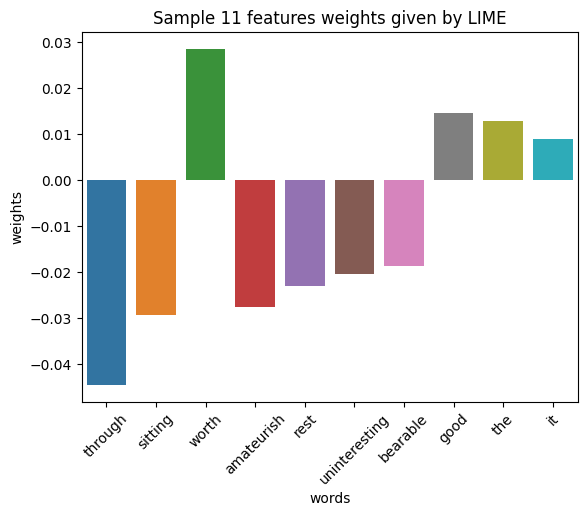

In [20]:
# We choose a sample from test set
idx = 11
text_sample = test_texts[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 1000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[test_labels[idx]])



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));